In [2]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
train_ratio = 0.8  # 80% for training, 20% for validation

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

print(NUM_WORKERS)

c:\Users\edine\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4


In [3]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        with open(os.path.join(json_dir, filename), 'r') as f:
            ground_data = json.load(f)
            segments = ground_data['segments']
            grass_positions = ground_data['grassPositions']
            # check if ground data contains starting point
            if 'startingPoint' in ground_data:
                starting_point = ground_data['startingPoint']
            else:
                starting_point = all_starting_points[-1]

            # Append data to lists
            all_segments.append(segments)
            all_grass_positions.append(grass_positions)
            all_starting_points.append(starting_point)

In [4]:
segments_list = []
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['x'], point['y'], point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)


In [5]:
train_size = int(len(segments_tensor) * train_ratio)  # % for training
val_size = len(segments_tensor) - train_size  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 403
Validation dataset size: 101


In [6]:
# Define the discriminator model
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Define the generator model
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(LSTMGenerator, self).__init__()
        self.hidden_size1 = hidden_size1
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)
        self.fc3 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        out = out[:, -1, :]  # Take the output from the last time step
        
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [88]:

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for x and y only
hidden_size_discriminator1 = 256
hidden_size_discriminator2 = 128
hidden_size_discriminator3 = 64
output_size_discriminator = 1

input_size_generator = 32
hidden_size_generator1 = 64
hidden_size_generator2 = 128
hidden_size_generator3 = 256
output_size_generator = 1710  # Output size should match the size of each segment for x and y only

discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
                                  hidden_size_discriminator2, hidden_size_discriminator3,
                                  output_size_discriminator)
generator = LSTMGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, output_size_generator)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00025, betas=(0.85, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0008, betas=(0.85, 0.999))

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)

    interpolated_prob = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_prob,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_prob.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # penalize negative values and values greater than 0.7
    penalty = torch.relu(-lengths) + torch.relu(lengths - 0.7)
    penalty = torch.sum(penalty)
    return penalty

def angle_loss(angles):
    # Compute the absolute difference between angles and the horizontal direction (0 degrees)
    horizontal_angles = torch.zeros_like(angles)  # Horizontal direction (0 degrees)
    angle_diff = torch.abs(angles - horizontal_angles)
    
    # Penalize angles that deviate too much from the horizontal direction
    max_deviation_deg = 60  # Maximum allowed deviation from horizontal (10 degrees)
    max_deviation_rad = torch.deg2rad(torch.tensor(max_deviation_deg))  # Convert degrees to radians
    angle_penalty = torch.relu(angle_diff - max_deviation_rad)
    
    # Sum up the penalties for all angles
    total_penalty = torch.sum(angle_penalty)
    
    return total_penalty

def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)



# Training loop
num_epochs = 200
lambda_penalty = 10.0  # Weight for the length penalty loss
lambda_difference = 25.0  # Weight for the length difference loss

for epoch in range(num_epochs):
    for real_data in train_dataloader:
        real_labels = torch.ones(len(real_data), 1)
        fake_labels = torch.zeros(len(real_data), 1)

        real_data = real_data.float().view(real_data.size(0), -1)  # Flatten the input data

        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)
        real_score = real_output

        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
        fake_data = generator(z)
        fake_data = fake_data.view(fake_data.size(0), -1)  # Flatten the fake data

        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        fake_score = fake_output

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
        fake_data = generator(z)
        output = discriminator(fake_data.view(fake_data.size(0), -1))  # Flatten the fake data

        g_loss = criterion(output, real_labels)

        # Add the length penalty loss
        length_penalty = length_penalty_loss(fake_data, len(real_data))

        # Add the length difference loss
        real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for real data
        fake_lengths = torch.norm(fake_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for fake data
        difference_loss = length_difference_loss(real_lengths, fake_lengths)

        # Calculate the total generator loss
        total_g_loss = g_loss + lambda_penalty * length_penalty + lambda_difference * difference_loss

        g_optimizer.zero_grad()
        total_g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, length_penalty: {length_penalty.item():.4f}, difference_loss: {difference_loss.item():.4f}')


# After training, generate new fake data
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

Epoch [1/200], d_loss: 0.8606, g_loss: 2145.7654, length_penalty: 158.0616, difference_loss: 22.5787
Epoch [2/200], d_loss: 0.7254, g_loss: 1016.1827, length_penalty: 44.9466, difference_loss: 22.6415
Epoch [3/200], d_loss: 0.7136, g_loss: 604.9310, length_penalty: 4.7378, difference_loss: 22.2749
Epoch [4/200], d_loss: 0.7002, g_loss: 563.9788, length_penalty: 0.1372, difference_loss: 22.4765
Epoch [5/200], d_loss: 0.6832, g_loss: 551.1659, length_penalty: 0.0000, difference_loss: 22.0183
Epoch [6/200], d_loss: 0.6654, g_loss: 546.1660, length_penalty: 0.0000, difference_loss: 21.8175
Epoch [7/200], d_loss: 0.6387, g_loss: 552.8636, length_penalty: 0.0000, difference_loss: 22.0842
Epoch [8/200], d_loss: 0.5988, g_loss: 539.3903, length_penalty: 0.0041, difference_loss: 21.5414
Epoch [9/200], d_loss: 0.5277, g_loss: 539.4695, length_penalty: 0.0000, difference_loss: 21.5420
Epoch [10/200], d_loss: 0.4249, g_loss: 541.2354, length_penalty: 0.0000, difference_loss: 21.6055
Epoch [11/200]

[{'segments': [{'length': 0.17031265795230865, 'angleToNextVector': -21.580074310302734}, {'length': 0.20612812042236328, 'angleToNextVector': 21.204015731811523}, {'length': 0.2984289228916168, 'angleToNextVector': 21.083282470703125}, {'length': 0.4055517613887787, 'angleToNextVector': 21.447093963623047}, {'length': 0.4172837734222412, 'angleToNextVector': 21.087417602539062}, {'length': 0.41092342138290405, 'angleToNextVector': 21.25515365600586}, {'length': 0.16682100296020508, 'angleToNextVector': -22.65228843688965}, {'length': 0.35701698064804077, 'angleToNextVector': 21.304872512817383}, {'length': 0.23606112599372864, 'angleToNextVector': 21.765605926513672}, {'length': 0.14467987418174744, 'angleToNextVector': 21.412187576293945}, {'length': 0.2669484317302704, 'angleToNextVector': -21.41167449951172}, {'length': 0.15140388906002045, 'angleToNextVector': -21.54496192932129}, {'length': 0.17922541499137878, 'angleToNextVector': -21.207321166992188}, {'length': 0.3532890677452

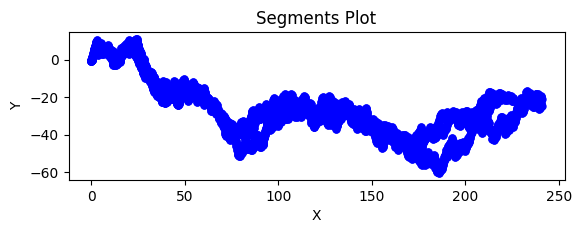

In [92]:
# After training, generate new fake data
z = torch.randn(4, input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            if tmpangle < 0:
                tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle) 
            new_y = y + length * np.sin(angle) * 10
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)




[{'segments': [{'length': 0.034486908465623856, 'angleToNextVector': -0.015647152438759804}, {'length': -0.029202928766608238, 'angleToNextVector': -0.07264924794435501}, {'length': 0.053666528314352036, 'angleToNextVector': 0.02926437370479107}, {'length': -0.005548290908336639, 'angleToNextVector': 0.08544771373271942}, {'length': -0.06420019268989563, 'angleToNextVector': 0.04313534498214722}, {'length': 0.06399485468864441, 'angleToNextVector': 0.07721436023712158}, {'length': 0.05203206092119217, 'angleToNextVector': -0.04488428309559822}, {'length': 0.05510715767741203, 'angleToNextVector': 0.015131417661905289}, {'length': -0.019677162170410156, 'angleToNextVector': 0.0006208731792867184}, {'length': 0.04435653239488602, 'angleToNextVector': 0.012497007846832275}, {'length': -0.015038013458251953, 'angleToNextVector': -0.025427531450986862}, {'length': -0.026558343321084976, 'angleToNextVector': 0.06110391393303871}, {'length': -0.02426823228597641, 'angleToNextVector': 0.041409

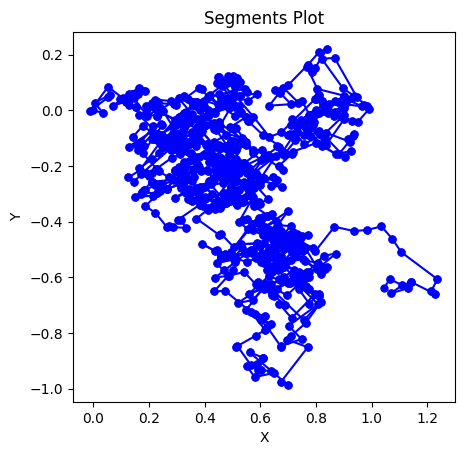

In [53]:
generator = LSTMGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, output_size_generator)

# After training, generate new fake data
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

plot_segments_from_json(generated_data)
